{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

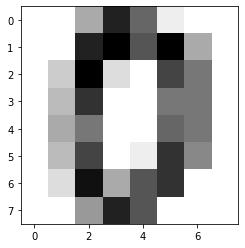

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from torchsummary import summary

digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
digits

In [14]:
n_sample = len(digits.images)
X = digits.images.reshape((n_sample, -1))

# 얘는 평탄화 작업이 필요 없고 결과는 차이 없음.
# X = digits.data.reshape((n_sample, -1))

y = digits.target

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape((-1, 1, 8, 8))  # CNN 입력을 위한 reshape

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # CrossEntropyLoss expects long (정수 클래스 인덱스)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 데이터로더
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# 데이터 형태 확인
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(y)

X_train shape: torch.Size([1437, 1, 8, 8]), y_train shape: torch.Size([1437])
X_test shape: torch.Size([360, 1, 8, 8]), y_test shape: torch.Size([360])
[0 1 2 ... 8 9 8]


In [17]:
# CNN 모델 정의
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # input: [B,1,8,8] -> [B,16,8,8]
        self.pool = nn.MaxPool2d(2, 2)  # [B,16,8,8] -> [B,16,4,4]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # [B,32,4,4]
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B,16,4,4]
        x = self.pool(F.relu(self.conv2(x)))  # [B,32,2,2]
        x = x.view(-1, 32 * 2 * 2)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [18]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# 학습
train_losses = []
test_accuracies = []
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 2.1724, Accuracy: 56.11%
Epoch 2/30, Loss: 1.4314, Accuracy: 83.33%
Epoch 3/30, Loss: 0.7734, Accuracy: 87.78%
Epoch 4/30, Loss: 0.4917, Accuracy: 92.78%
Epoch 5/30, Loss: 0.3653, Accuracy: 94.17%
Epoch 6/30, Loss: 0.2740, Accuracy: 96.94%
Epoch 7/30, Loss: 0.2302, Accuracy: 97.50%
Epoch 8/30, Loss: 0.1981, Accuracy: 98.33%
Epoch 9/30, Loss: 0.1900, Accuracy: 98.06%
Epoch 10/30, Loss: 0.1498, Accuracy: 98.61%
Epoch 11/30, Loss: 0.1365, Accuracy: 99.17%
Epoch 12/30, Loss: 0.0984, Accuracy: 98.89%
Epoch 13/30, Loss: 0.0999, Accuracy: 98.89%
Epoch 14/30, Loss: 0.0836, Accuracy: 99.44%
Epoch 15/30, Loss: 0.0747, Accuracy: 99.17%
Epoch 16/30, Loss: 0.0698, Accuracy: 98.89%
Epoch 17/30, Loss: 0.0650, Accuracy: 98.89%
Epoch 18/30, Loss: 0.0771, Accuracy: 99.17%
Epoch 19/30, Loss: 0.0505, Accuracy: 99.17%
Epoch 20/30, Loss: 0.0480, Accuracy: 99.17%
Epoch 21/30, Loss: 0.0431, Accuracy: 99.17%
Epoch 22/30, Loss: 0.0352, Accuracy: 99.44%
Epoch 23/30, Loss: 0.0362, Accuracy: 98.6

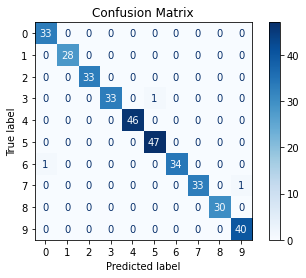


Precision (macro): 0.99
Recall (macro): 0.99
F1 Score (macro): 0.99

Classification Report:
              precision    recall  f1-score   support

           0      0.971     1.000     0.985        33
           1      1.000     1.000     1.000        28
           2      1.000     1.000     1.000        33
           3      1.000     0.971     0.985        34
           4      1.000     1.000     1.000        46
           5      0.979     1.000     0.989        47
           6      1.000     0.971     0.986        35
           7      1.000     0.971     0.985        34
           8      1.000     1.000     1.000        30
           9      0.976     1.000     0.988        40

    accuracy                          0.992       360
   macro avg      0.993     0.991     0.992       360
weighted avg      0.992     0.992     0.992       360



In [20]:
# 모델 평가
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 정밀도, 재현율, F1 점수
f1 = f1_score(all_labels, all_predictions, average='macro')
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"\nPrecision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1 Score (macro): {f1:.2f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, digits=3))

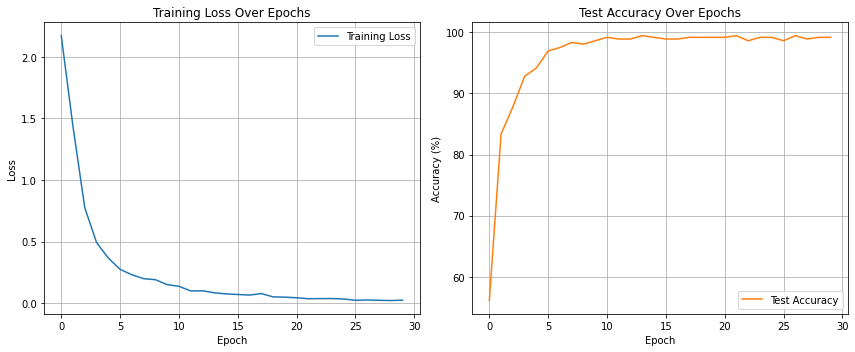

In [21]:
# 손실과 정확도 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()